In [27]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data
from ISLP.models import ModelSpec as MS

from sklearn.tree import (
    DecisionTreeRegressor as DTR,
    plot_tree,
)
from sklearn.ensemble import (
    RandomForestRegressor as RF,
)
from ISLP.bart import BART

In [28]:
Carseats = load_data('Carseats')
Carseats 

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [29]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

### (a)

In [30]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Carseats['Sales'], test_size=0.3, random_state=0
)

### (b)

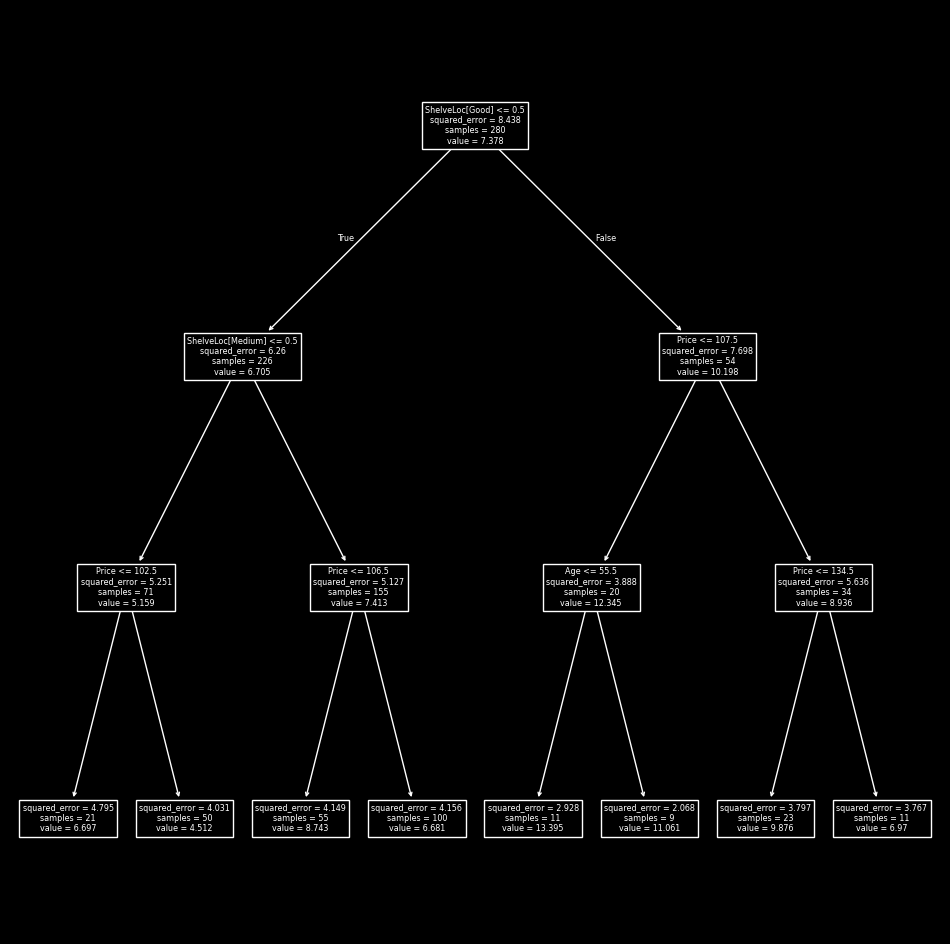

In [31]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12, 12))[1]
plot_tree(reg, feature_names=feature_names, ax=ax);


In [32]:
mse = np.mean((y_test - reg.predict(X_test))**2)
print(f'Test MSE is {mse:.2f}')

Test MSE is 3.70


The squired error of the root is 8.4, improving towords the leaves - MSE = 3.7

### (c)

In [33]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(
    DTR(),
    {"ccp_alpha": ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring="neg_mean_squared_error",
)
G = grid.fit(X_train, y_train)

In [34]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

3.932610060213901

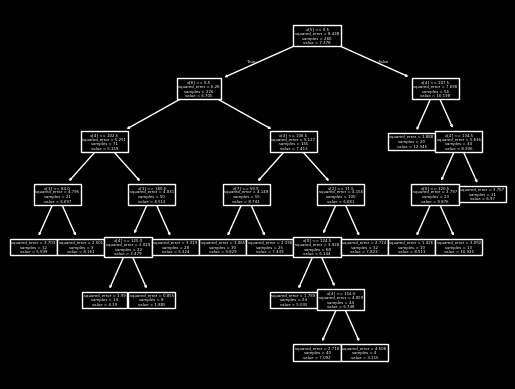

In [35]:
plot_tree(best_);

Pruning the tree in this case increases the test MSE to 4.35 comparing to 3.7 obtained in (b)

### (d)

In [36]:
bagging = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(
    X_train, y_train
)
y_hat_bag = bagging.predict(X_test)
np.mean((y_test - y_hat_bag) ** 2)

2.022762670943343

We obtained better MSE of 2.02 comparing to (c)

In [37]:
feature_imp = pd.DataFrame(
    {"importance": bagging.feature_importances_}, index=feature_names
)
feature_imp.sort_values(by="importance", ascending=False)

,importance
Price,0.286662
ShelveLoc[Good],0.220007
Age,0.105379
CompPrice,0.100636
ShelveLoc[Medium],0.085092
Advertising,0.068875
Income,0.053587
Population,0.039253
Education,0.029635
US[Yes],0.006531


Top-4 best featues are Price, ShelveLoc, Age, and CompPrice

### (e)

In [38]:
errors = []

for i in range(1, X_train.shape[1]):
    rf_i = RF(max_features=i, n_estimators=500, random_state=0).fit(
        X_train, y_train
    )
    y_hat_rf_i = rf_i.predict(X_test)    
    errors.append(np.mean((y_test - y_hat_rf_i) ** 2))

Text(0, 0.5, 'Test MSE')

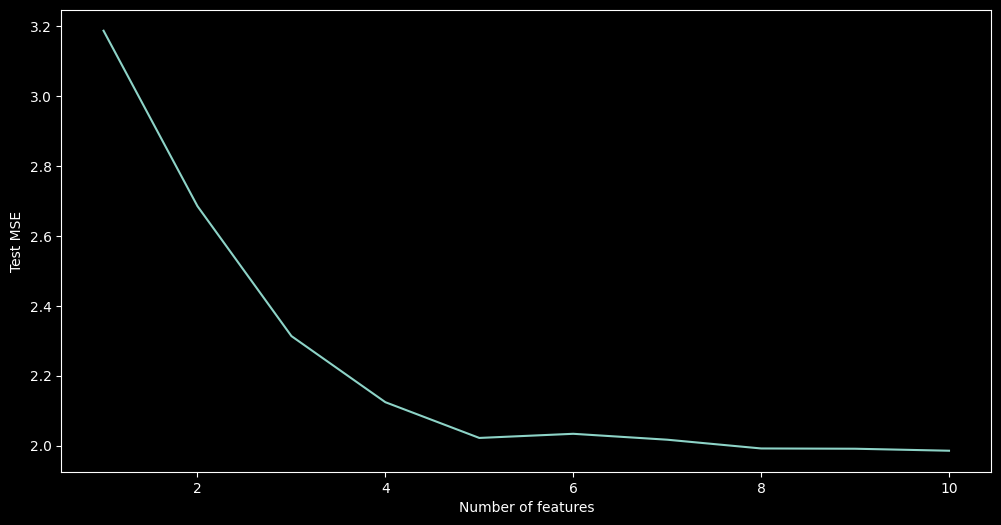

In [39]:
ax = subplots(figsize=(12, 6))[1]
ax.plot(range(1, X_train.shape[1]), errors)
ax.set_xlabel('Number of features')
ax.set_ylabel('Test MSE')

Best MSE obtained with random forest is similar to the one obtained by bagging: 2

In [40]:
# now we going to use "classical" random forest, where m ~ sqrt(p)
# we take m = 4 (~ sqrt(11))
rf = RF(max_features=4, n_estimators=500, random_state=0).fit(
    X_train, y_train
)

feature_imp = pd.DataFrame(
    {"importance": rf.feature_importances_}, index=feature_names
)
feature_imp.sort_values(by="importance", ascending=False)

,importance
Price,0.254397
ShelveLoc[Good],0.178323
Age,0.118732
CompPrice,0.097025
Advertising,0.082266
Income,0.079536
Population,0.065747
ShelveLoc[Medium],0.055386
Education,0.044855
US[Yes],0.013415


Top-3 features are Price, ShelveLoc, and Age

### (f)

In [41]:
bart = BART(random_state=0, burnin=5, ndraw=15)
bart.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [42]:
yhat_test = bart.predict(X_test)
np.mean((y_test - yhat_test)**2)

1.7171824254893664

In [43]:
# We can check how many times each variable appeared in the collection of trees. 
# This gives a summary similar to the variable importance plot for boosting and random forests.
var_inclusion = pd.Series(bart.variable_inclusion_.mean(0),index=D.columns)
var_inclusion

CompPrice            29.600000
Income               21.266667
Advertising          27.200000
Population           25.866667
Price                34.266667
ShelveLoc[Good]      33.266667
ShelveLoc[Medium]    27.266667
Age                  33.733333
Education            24.200000
Urban[Yes]           25.800000
US[Yes]              26.400000
dtype: float64